<a href="https://colab.research.google.com/github/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture2_Autoencoders_and_Generative_Adversarial_Networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
from IPython import display

# 1. Toy Model Waveforms

In [ ]:
def show_some_cases(dataset1, dataset2 = None):
    fig, ax = plt.subplots(2,3, figsize = (12, 4));

    x = np.linspace(-1, 1, 100, dtype = np.float32)
    for i in range(2):
        for j in range(3):
            ax[i,j].plot(x, dataset1[j + 3*i, :], 'b')
            if dataset2 is not None:
                ax[i,j].plot(x, dataset2[j + 3*i, :], 'r--')

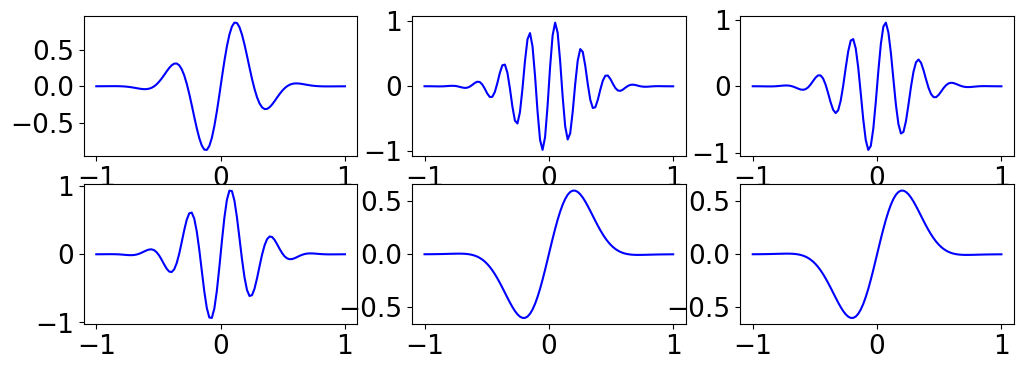

In [40]:
np.random.seed(42)

x       = np.linspace(-1, 1, 100, dtype = np.float32)
randoms = 5*np.random.rand(1000)
data    = torch.tensor(np.array([    np.sin(2 * k * np.pi * x) * np.exp(- 8 * x**2 ) for k in randoms]))

show_some_cases(data)

# 2. Principal Component Analysis / Singular Value Decomposition

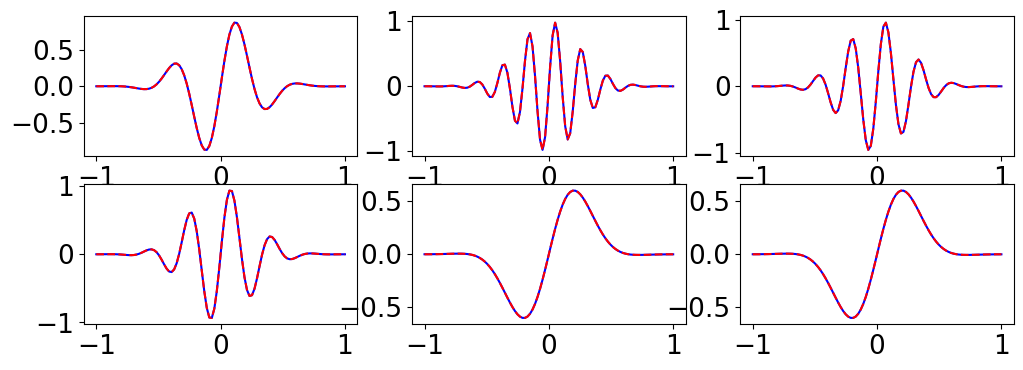

In [41]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = TruncatedSVD(n_components = 10)
pca.fit(data)

encoded = pca.transform(data)
decoded = pca.inverse_transform(encoded)

show_some_cases(data, decoded)

# 3. Autoencoder

In [35]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 100)
        )

        torch.manual_seed(0)
        for m in self.encoder.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.01)
                nn.init.constant_(m.bias, val = 0.0)
    
        for m in self.decoder.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.01)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.decoder(self.encoder(x))
    

## 3. 1. Training with 1-parameter dependence

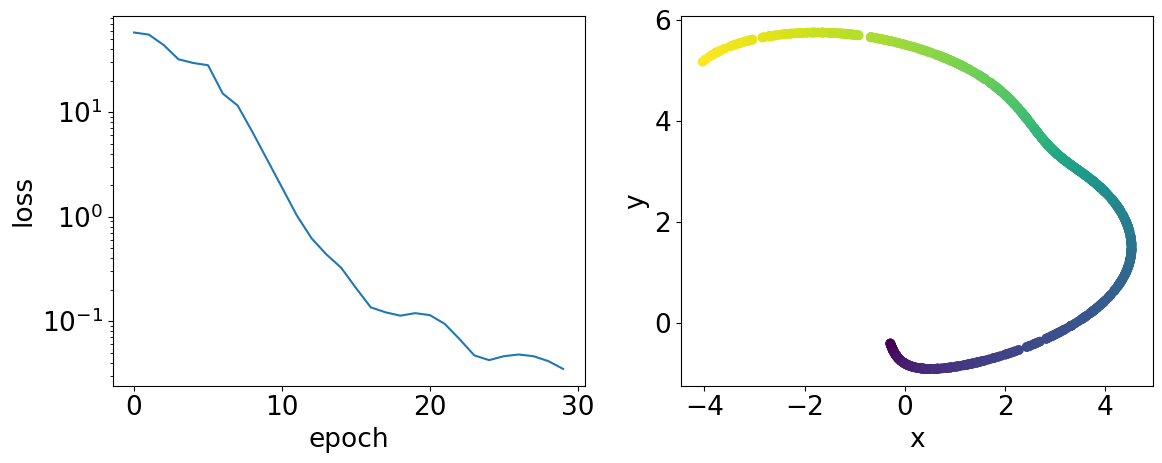

In [44]:
auto_encoder  = AutoEncoder()

loss_hist = []

optimizer = optim.Adam(auto_encoder.parameters(), lr=0.001)

data_loader = DataLoader(data,  batch_size=10, num_workers=8, pin_memory=True)

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(30):
    try:
        for X in data_loader:

            optimizer.zero_grad()
            
            reconstructed = auto_encoder(X)
            loss = torch.sum((X - reconstructed)**2)
            
            loss.backward()
            optimizer.step()
            
        loss_hist.append(loss.item())
        latent = auto_encoder.encoder(data).detach().numpy()

        ax1.cla()
        ax1.set_yscale('log')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(loss_hist)

        ax2.cla()
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.scatter(latent[:,0], latent[:,1], c = randoms)

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

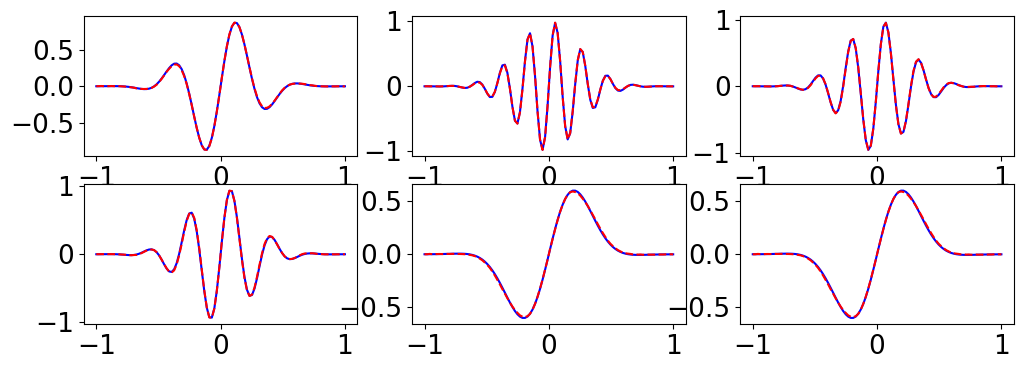

In [45]:
encoded = auto_encoder.encoder(data)
decoded = auto_encoder.decoder(encoded)

show_some_cases(data, decoded.cpu().detach().numpy())

## 3.2. Let's try a 2-parameter dependence

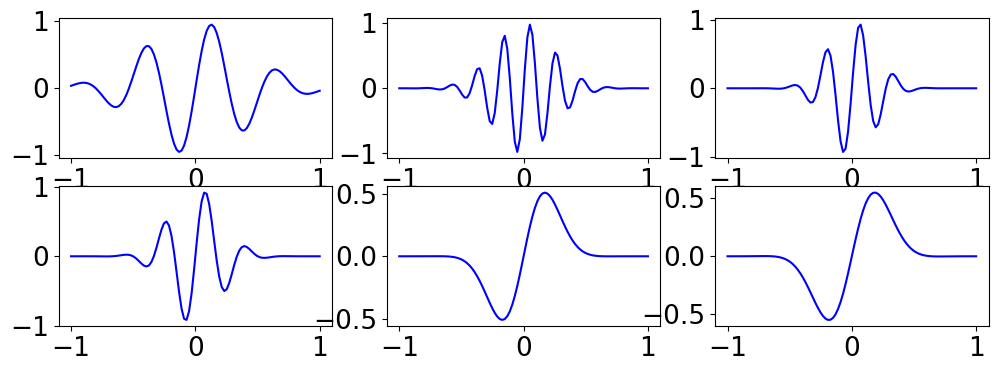

In [47]:
np.random.seed(42)

x        = np.linspace(-1, 1, 100, dtype = np.float32)
randoms1 = 5*np.random.rand(1000)
randoms2 = 2*np.random.rand(1000)
data     = torch.tensor(np.array([    np.sin(2 * k1 * np.pi * x) * np.exp(- k2 * 8 * x**2 ) \
                                  for k1, k2 in zip(randoms1, randoms2)]))

show_some_cases(data)

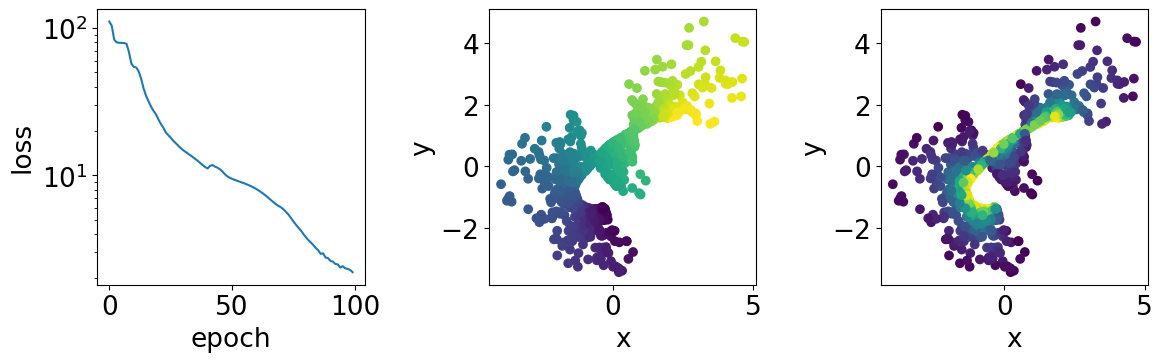

In [52]:
auto_encoder  = AutoEncoder()

loss_hist = []

optimizer = optim.Adam(auto_encoder.parameters(), lr=0.001)

data_loader = DataLoader(data,  batch_size=10, num_workers=8, pin_memory=True)


################## Training and Plotting ##################

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(100):
    try:
        for X in data_loader:

            optimizer.zero_grad()
            
            reconstructed = auto_encoder(X)
            loss = torch.sum((X - reconstructed)**2)
            
            loss.backward()
            optimizer.step()
            
        loss_hist.append(loss.item())
        latent = auto_encoder.encoder(data).detach().numpy()

        ax1.cla()
        ax1.set_yscale('log')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(loss_hist)

        ax2.cla()
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.scatter(latent[:,0], latent[:,1], c = randoms1)
        
        ax3.cla()
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.scatter(latent[:,0], latent[:,1], c = randoms2)

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

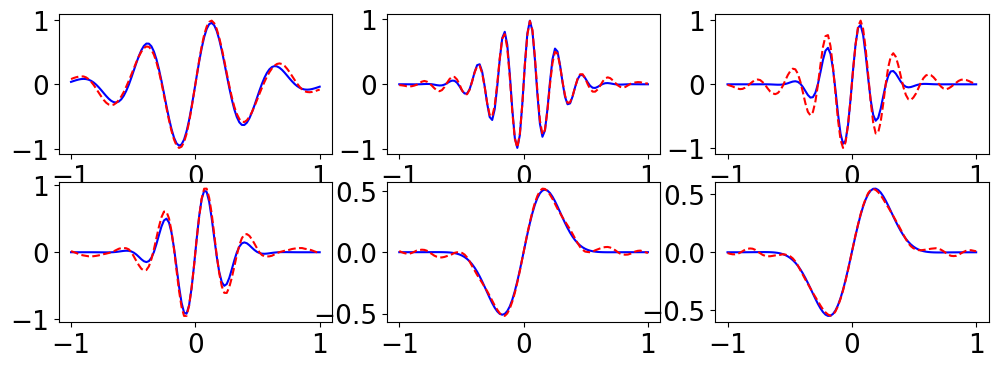

In [53]:
encoded = auto_encoder.encoder(data)
decoded = auto_encoder.decoder(encoded)

show_some_cases(data, decoded.cpu().detach().numpy())

# 4. Generative Adversarial Networks (GANs)

In [ ]:
X = torch.normal(0., 1., (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.02)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5,3),
            nn.Tanh(),
            nn.Linear(3,1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.02)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, x):
        return self.net(x)

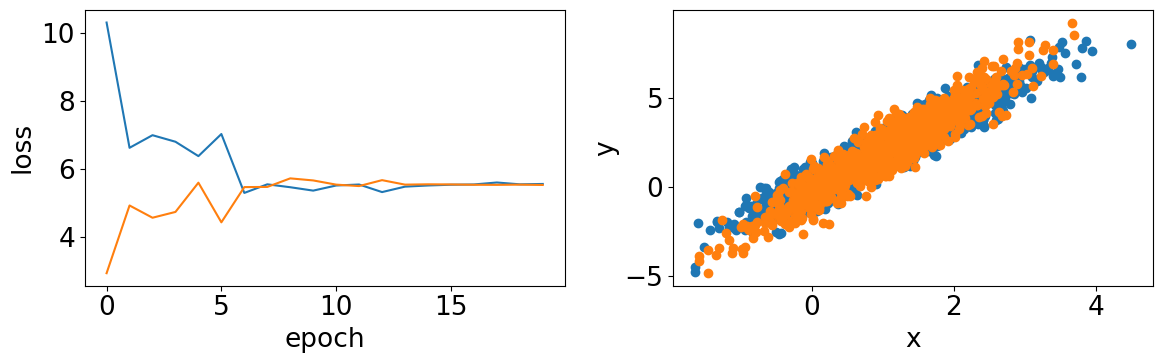

In [ ]:
generator     = Generator()
discriminator = Discriminator()

gen_loss_hist = []
dis_loss_hist = []

gen_optimizer = optim.Adam(generator.parameters(), lr=0.005)
dis_optimizer = optim.Adam(discriminator.parameters(), lr=0.05)

data_loader = DataLoader(data,  batch_size=8, num_workers=8, pin_memory=True)

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(20):
    try:
        for X in data_loader:
            loss_function = nn.BCEWithLogitsLoss(reduction='sum')
            latent_space_points = torch.normal(0, 1, size=(8, 2))

            ################## Train the Discriminator ##################
            dis_optimizer.zero_grad()
            fake_data = generator(latent_space_points)

            real_data_evaluation = discriminator(X)
            fake_data_evaluation = discriminator(fake_data.detach())

            real_data_loss = loss_function(real_data_evaluation, torch.ones(8, 1))
            fake_data_loss = loss_function(fake_data_evaluation, torch.zeros(8, 1))

            dis_loss = (real_data_loss + fake_data_loss)/2
            
            dis_loss.backward()
            dis_optimizer.step()
            #############################################################

            #################### Train the Generator ####################
            gen_optimizer.zero_grad()
            fake_data = generator(latent_space_points)

            fake_data_evaluation = discriminator(fake_data)
            gen_loss = loss_function(fake_data_evaluation, torch.ones(8, 1))

            gen_loss.backward()
            gen_optimizer.step()                             
            #############################################################
        
        dis_loss_hist.append(dis_loss.item())
        gen_loss_hist.append(gen_loss.item())
        
        latent_space_points = torch.normal(0, 1, size=(1000, 2))
        fake_data = generator(latent_space_points).cpu().detach().numpy()
        real_data = data

        ax1.cla()
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(gen_loss_hist)
        ax1.plot(dis_loss_hist)

        ax2.cla()
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.scatter(real_data[:, 0], real_data[:, 1])
        ax2.scatter(fake_data[:, 0], fake_data[:, 1])

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.tight_layout()
            
    except KeyboardInterrupt:
        break
        

# 5. Deep Convolutional GAN for waveforms

In [58]:
wave_size  = 64
batch_size = 64
lr         = 0.0002
beta1      = 0.5
niter      = 25

nz  = 100   # Size of latent vector
ngf = 64    # Filter size of generator
ndf = 64    # Filter size of discriminator
nc  = 1     # Output wave channels

In [61]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
def show_some_cases(dataset):
    fig, ax = plt.subplots(2,3, figsize = (12, 4));
    font = {'size'   : 12}
    plt.rc('font', **font)

    x = np.linspace(-1, 1, 64, dtype = np.float32)
    for i in range(2):
        for j in range(3):
            ax[i,j].plot(x, dataset[j + 3*i, 0, :])

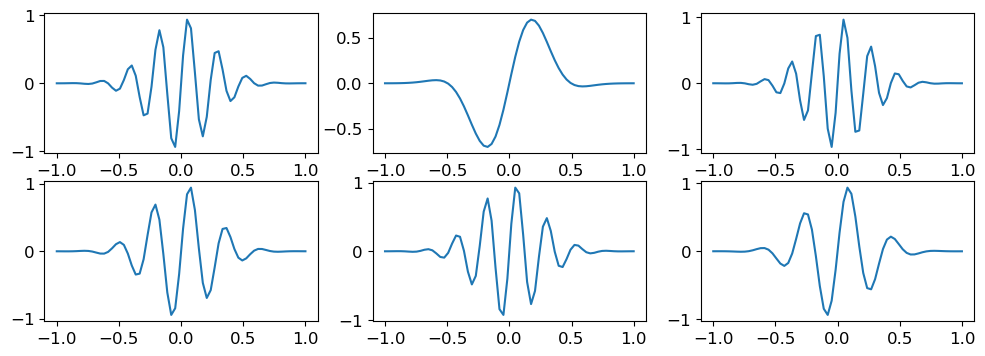

In [62]:
x       = np.linspace(-1, 1, 64, dtype = np.float32)
randoms = 5 * np.random.rand(1024)
data    = torch.tensor(np.array([    np.sin(2 * k * np.pi * x) * np.exp(- 8 * x**2 ) for k in randoms])).reshape(1024, 1, 64)

show_some_cases(data)

In [63]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose1d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose1d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose1d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose1d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose1d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.net(input)
        return output

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv1d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv1d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv1d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv1d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv1d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.net(input)
        return output.view(-1, 1).squeeze(1)

In [64]:
generator     = Generator().cuda()
discriminator = Discriminator().cuda()

generator.apply(weights_init)
discriminator.apply(weights_init)

gen_optimizer = optim.Adam(generator.parameters(), lr, betas=(beta1, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr, betas=(beta1, 0.999))
loss_function = nn.BCELoss().cuda()

data_loader   = DataLoader(data, batch_size = batch_size, shuffle=True)
gen_loss_hist = []
dis_loss_hist = []

for epoch in range(niter):
    print(epoch, end = ' ')
    for i, X in enumerate(data_loader, 0):
        
        X_cuda = X.cuda()
        latent_space_points = torch.normal(0, 1, size = (batch_size, nz, 1)).cuda()
        
        ################## Train the Discriminator ##################
        
        discriminator.zero_grad()

        fake_data = generator(latent_space_points)

        real_data_evaluation = discriminator(X_cuda)
        fake_data_evaluation = discriminator(fake_data.detach())

        real_data_loss = loss_function(real_data_evaluation, torch.ones(batch_size).cuda())
        fake_data_loss = loss_function(fake_data_evaluation, torch.zeros(batch_size).cuda())

        dis_loss = (real_data_loss + fake_data_loss) / 2

        dis_loss.backward()
        dis_optimizer.step()

        #############################################################

        #################### Train the Generator ####################
        
        gen_optimizer.zero_grad()
        fake_data = generator(latent_space_points)

        fake_data_evaluation = discriminator(fake_data)
        gen_loss = loss_function(fake_data_evaluation, torch.ones(batch_size).cuda())

        gen_loss.backward()
        gen_optimizer.step()  

        #############################################################


RuntimeError: No CUDA GPUs are available

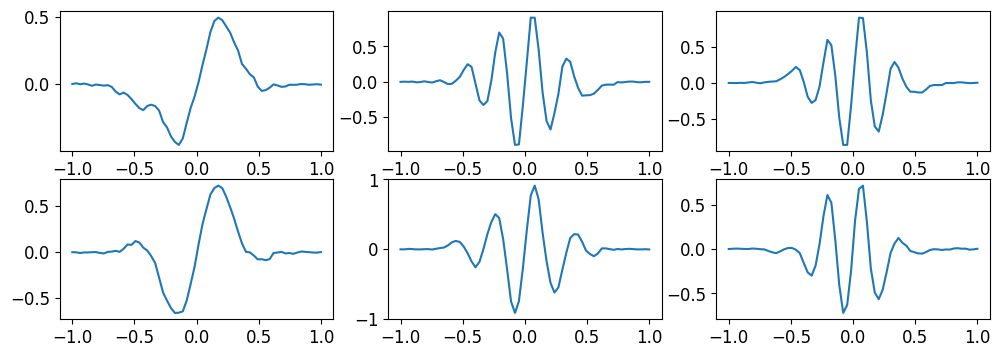

In [137]:
fixed_noise = torch.normal(0, 1, size = (6, nz, 1)).cuda()
test = generator(fixed_noise)
show_some_cases(test.cpu().detach().numpy())